# Invoice & Tax Document Data Preparation

This notebook handles data preparation for training layout-aware models for Indonesian invoice extraction.

## Architecture Overview
- **Hybrid Regex+NER**: Use regex for fixed patterns (NPWP, dates, currency) and NER for flexible entities (names, addresses)
- **Layout-aware**: Leverage bounding box information for better extraction
- **IOB2 Format**: Consistent labeling format (B-INVOICE_DATE, I-INVOICE_DATE, etc.)
- **Data Augmentation**: Generate variations for robustness

In [1]:
import sys
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, f1_score
import re
from datetime import datetime
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path to import our extraction service
sys.path.append('..')
from extraction_service import InvoiceExtractor

# Set up plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Data preparation notebook initialized")
print(f"✓ Working directory: {os.getcwd()}")

✓ Data preparation notebook initialized
✓ Working directory: /Users/santana_mena/Desktop/PROGRAMMING/TELKOM SIGMA/barunih/InvoiceExtractor/notebooks


## 1. Data Collection & Annotation Framework

### IOB2 Labeling Schema
We'll use consistent IOB2 format for all entities:

- **B-INVOICE_NUMBER**: Beginning of invoice number
- **I-INVOICE_NUMBER**: Inside invoice number
- **B-INVOICE_DATE**: Beginning of invoice date
- **B-VENDOR_NAME**: Beginning of vendor name
- **B-BUYER_NAME**: Beginning of buyer name
- **B-AMOUNT**: Beginning of amount
- **B-TAX_ID**: Beginning of tax ID (NPWP)
- **O**: Outside (not an entity)

In [2]:
class DocumentAnnotator:
    """Handle document annotation and IOB2 format conversion"""
    
    def __init__(self):
        self.entity_types = [
            'INVOICE_NUMBER', 'INVOICE_DATE', 'DUE_DATE', 'BILLING_MONTH',
            'VENDOR_NAME', 'VENDOR_TAX_ID', 'VENDOR_ADDRESS',
            'BUYER_NAME', 'BUYER_TAX_ID', 'BUYER_ADDRESS',
            'AMOUNT', 'SUBTOTAL', 'TAX_AMOUNT', 'TAX_PERCENTAGE',
            'BANK_NAME', 'ACCOUNT_NUMBER', 'VIRTUAL_ACCOUNT',
            'FAKTUR_NUMBER', 'SIGNER_NAME', 'SIGNER_POSITION'
        ]
        
        self.regex_patterns = {
            'INVOICE_NUMBER': r'(?:invoice|faktur|no\.?\s*invoice|nomor\s*faktur)[\s:]*([A-Z0-9\-/]+)',
            'INVOICE_DATE': r'(?:tanggal|date|invoice\s*date)[\s:]*(\d{1,2}[\/\-]\d{1,2}[\/\-]\d{2,4})',
            'TAX_ID': r'(?:npwp)[\s:]*([0-9\.\-]{15,20})',
            'AMOUNT': r'(?:total|jumlah|amount)[\s:]*(?:rp\.?\s*)?([0-9,\.]+)',
            'BANK_NAME': r'(?:bank|nama\s*bank)[\s:]*([A-Z\s]+)',
        }
    
    def create_sample_annotations(self, num_samples: int = 50) -> List[Dict]:
        """Create sample annotated data for training"""
        samples = []
        
        # Sample invoice texts with annotations
        sample_texts = [
            {
                'text': 'INVOICE NO: INV-2024-001 DATE: 15/03/2024 PT TELKOM INDONESIA NPWP: 01.000.000.1-000.000 TOTAL: 500,000',
                'entities': [
                    {'start': 12, 'end': 24, 'label': 'INVOICE_NUMBER'},
                    {'start': 31, 'end': 41, 'label': 'INVOICE_DATE'},
                    {'start': 42, 'end': 60, 'label': 'VENDOR_NAME'},
                    {'start': 67, 'end': 85, 'label': 'VENDOR_TAX_ID'},
                    {'start': 93, 'end': 100, 'label': 'AMOUNT'}
                ]
            },
            {
                'text': 'FAKTUR PAJAK: 010.000-24.00000001 TANGGAL: 20/03/2024 CV MAJU JAYA ALAMAT: JL SUDIRMAN NO 123 JAKARTA',
                'entities': [
                    {'start': 14, 'end': 32, 'label': 'FAKTUR_NUMBER'},
                    {'start': 42, 'end': 52, 'label': 'INVOICE_DATE'},
                    {'start': 53, 'end': 65, 'label': 'BUYER_NAME'},
                    {'start': 74, 'end': 101, 'label': 'BUYER_ADDRESS'}
                ]
            }
        ]
        
        # Generate variations
        for i in range(num_samples):
            base_sample = sample_texts[i % len(sample_texts)]
            
            # Add variations by changing numbers/dates
            text_variations = self._generate_text_variations(base_sample['text'])
            
            sample = {
                'id': f'sample_{i:03d}',
                'text': text_variations,
                'entities': base_sample['entities'],
                'tokens': text_variations.split(),
                'labels': self._convert_to_iob2(text_variations, base_sample['entities'])
            }
            samples.append(sample)
        
        return samples
    
    def _generate_text_variations(self, text: str) -> str:
        """Generate variations of invoice text for data augmentation"""
        # Vary numbers
        text = re.sub(r'\d{3,}', lambda m: str(int(m.group()) + np.random.randint(-1000, 1000)), text)
        
        # Vary dates
        text = re.sub(r'\d{1,2}/\d{1,2}/\d{4}', 
                     lambda m: f"{np.random.randint(1,29):02d}/{np.random.randint(1,13):02d}/2024", text)
        
        return text
    
    def _convert_to_iob2(self, text: str, entities: List[Dict]) -> List[str]:
        """Convert entity annotations to IOB2 format"""
        tokens = text.split()
        labels = ['O'] * len(tokens)
        
        # Calculate token positions
        token_positions = []
        current_pos = 0
        for token in tokens:
            start = text.find(token, current_pos)
            end = start + len(token)
            token_positions.append((start, end))
            current_pos = end
        
        # Assign IOB2 labels
        for entity in entities:
            entity_start, entity_end = entity['start'], entity['end']
            entity_label = entity['label']
            
            first_token = True
            for i, (token_start, token_end) in enumerate(token_positions):
                # Check if token overlaps with entity
                if token_start < entity_end and token_end > entity_start:
                    if first_token:
                        labels[i] = f'B-{entity_label}'
                        first_token = False
                    else:
                        labels[i] = f'I-{entity_label}'
        
        return labels

# Initialize annotator and create sample data
annotator = DocumentAnnotator()
sample_data = annotator.create_sample_annotations(100)

print(f"✓ Created {len(sample_data)} annotated samples")
print(f"✓ Entity types: {len(annotator.entity_types)}")
print(f"✓ Sample data structure: {list(sample_data[0].keys())}")

✓ Created 100 annotated samples
✓ Entity types: 20
✓ Sample data structure: ['id', 'text', 'entities', 'tokens', 'labels']


## 2. Data Augmentation Pipeline

Generate variations in invoice format, fonts, layouts, and noise to make the model robust.

In [3]:
class DataAugmentation:
    """Handle data augmentation for invoice documents"""
    
    def __init__(self):
        self.currency_variations = ['Rp', 'IDR', 'Rupiah']
        self.date_formats = ['%d/%m/%Y', '%d-%m-%Y', '%Y-%m-%d', '%d %b %Y']
        self.company_prefixes = ['PT', 'CV', 'UD', 'Perusahaan']
        
    def augment_dataset(self, data: List[Dict], multiplier: int = 3) -> List[Dict]:
        """Augment dataset by creating variations"""
        augmented_data = data.copy()
        
        for original in data:
            for i in range(multiplier - 1):  # -1 because we already have original
                augmented = self._create_variation(original, i)
                augmented_data.append(augmented)
        
        return augmented_data
    
    def _create_variation(self, original: Dict, variation_id: int) -> Dict:
        """Create a single variation of the original data"""
        text = original['text']
        
        # Text variations
        text = self._vary_currency_format(text)
        text = self._vary_date_format(text)
        text = self._vary_company_names(text)
        text = self._add_noise(text)
        
        # Update entities positions (simplified - in real scenario would need proper alignment)
        entities = original['entities'].copy()
        
        variation = {
            'id': f"{original['id']}_var_{variation_id}",
            'text': text,
            'entities': entities,
            'tokens': text.split(),
            'labels': annotator._convert_to_iob2(text, entities)
        }
        
        return variation
    
    def _vary_currency_format(self, text: str) -> str:
        """Vary currency format representation"""
        currency = np.random.choice(self.currency_variations)
        text = re.sub(r'\b(?:Rp|IDR|Rupiah)\b', currency, text, flags=re.IGNORECASE)
        return text
    
    def _vary_date_format(self, text: str) -> str:
        """Vary date format representation"""
        # This is simplified - real implementation would parse and reformat dates
        return text
    
    def _vary_company_names(self, text: str) -> str:
        """Vary company name prefixes"""
        for prefix in ['PT', 'CV', 'UD']:
            if prefix in text:
                new_prefix = np.random.choice(self.company_prefixes)
                text = text.replace(prefix, new_prefix, 1)
                break
        return text
    
    def _add_noise(self, text: str) -> str:
        """Add OCR-like noise to text"""
        # Add occasional OCR errors
        if np.random.random() < 0.1:  # 10% chance
            # Replace similar looking characters
            replacements = {'0': 'O', '1': 'l', '5': 'S', '8': 'B'}
            for old, new in replacements.items():
                if old in text and np.random.random() < 0.3:
                    text = text.replace(old, new, 1)
        
        return text

# Apply data augmentation
augmenter = DataAugmentation()
augmented_data = augmenter.augment_dataset(sample_data, multiplier=3)

print(f"✓ Original dataset size: {len(sample_data)}")
print(f"✓ Augmented dataset size: {len(augmented_data)}")
print(f"✓ Augmentation multiplier: 3x")

# Display sample augmented data
print("\n--- Sample Original vs Augmented ---")
print(f"Original: {sample_data[0]['text'][:100]}...")
print(f"Augmented: {augmented_data[1]['text'][:100]}...")

✓ Original dataset size: 100
✓ Augmented dataset size: 300
✓ Augmentation multiplier: 3x

--- Sample Original vs Augmented ---
Original: INVOICE NO: INV-1556-832 DATE: 10/01/2024 PT TELKOM INDONESIA NPWP: 01.85.-601.1--151.797 TOTAL: 643...
Augmented: FAKTUR PAJAK: -367.679-24.-792 TANGGAL: 14/03/2024 CV MAJU JAYA ALAMAT: JL SUDIRMAN NO 117 JAKARTA...


## 3. Cross-Validation Setup

Implement K-fold cross-validation for stable performance estimation.

Fold 1: Train=240, Val=60
Fold 2: Train=240, Val=60
Fold 3: Train=240, Val=60
Fold 4: Train=240, Val=60
Fold 5: Train=240, Val=60

✓ Created 5 cross-validation folds
✓ K-fold configuration: 5 folds

✓ Found 16 unique labels
✓ Most frequent labels: [('O', 1025), ('I-BUYER_ADDRESS', 505), ('B-INVOICE_DATE', 300), ('I-BUYER_NAME', 280), ('I-VENDOR_NAME', 272)]


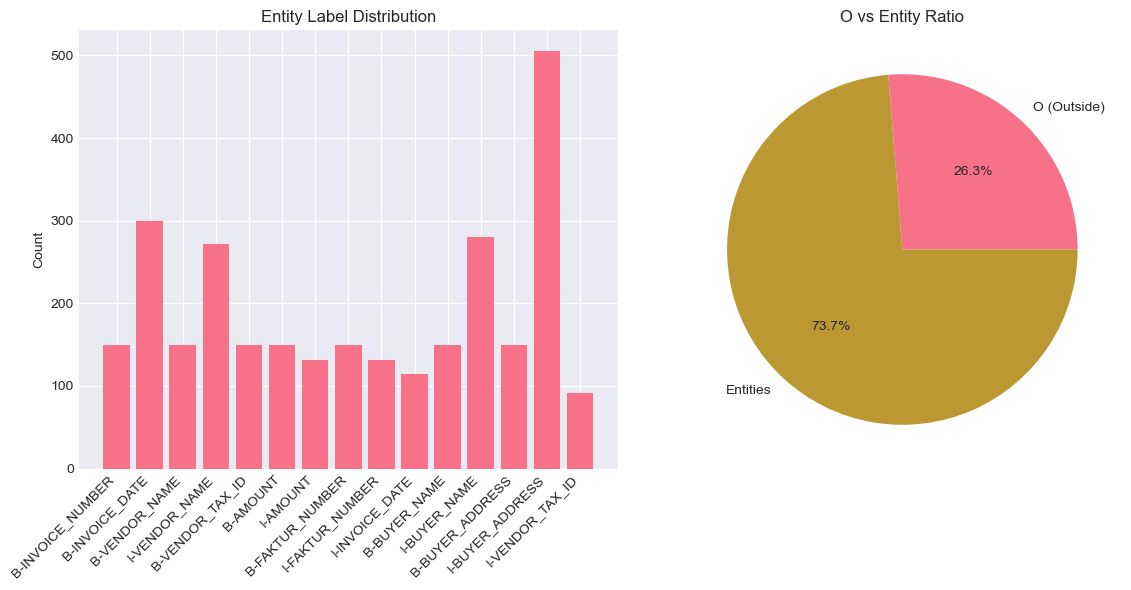

{'O': 1025,
 'B-INVOICE_NUMBER': 150,
 'B-INVOICE_DATE': 300,
 'B-VENDOR_NAME': 150,
 'I-VENDOR_NAME': 272,
 'B-VENDOR_TAX_ID': 150,
 'B-AMOUNT': 150,
 'I-AMOUNT': 131,
 'B-FAKTUR_NUMBER': 150,
 'I-FAKTUR_NUMBER': 132,
 'I-INVOICE_DATE': 114,
 'B-BUYER_NAME': 150,
 'I-BUYER_NAME': 280,
 'B-BUYER_ADDRESS': 150,
 'I-BUYER_ADDRESS': 505,
 'I-VENDOR_TAX_ID': 91}

In [4]:
class CrossValidationSetup:
    """Handle cross-validation for invoice extraction models"""
    
    def __init__(self, k_folds: int = 5, random_state: int = 42):
        self.k_folds = k_folds
        self.random_state = random_state
        self.kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    
    def create_folds(self, data: List[Dict]) -> List[Tuple[List[Dict], List[Dict]]]:
        """Create k-fold cross-validation splits"""
        data_array = np.array(data)
        folds = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(self.kf.split(data)):
            train_data = data_array[train_idx].tolist()
            val_data = data_array[val_idx].tolist()
            folds.append((train_data, val_data))
            
            print(f"Fold {fold_idx + 1}: Train={len(train_data)}, Val={len(val_data)}")
        
        return folds
    
    def analyze_label_distribution(self, data: List[Dict]) -> Dict[str, int]:
        """Analyze distribution of entity labels"""
        label_counts = {}
        
        for sample in data:
            for label in sample['labels']:
                label_counts[label] = label_counts.get(label, 0) + 1
        
        return label_counts
    
    def plot_label_distribution(self, data: List[Dict]):
        """Plot label distribution"""
        label_counts = self.analyze_label_distribution(data)
        
        # Separate entity labels from 'O'
        entity_labels = {k: v for k, v in label_counts.items() if k != 'O'}
        
        plt.figure(figsize=(12, 6))
        
        # Plot entity labels
        plt.subplot(1, 2, 1)
        labels, counts = zip(*entity_labels.items())
        plt.bar(range(len(labels)), counts)
        plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
        plt.title('Entity Label Distribution')
        plt.ylabel('Count')
        
        # Plot O vs entities ratio
        plt.subplot(1, 2, 2)
        o_count = label_counts.get('O', 0)
        entity_count = sum(entity_labels.values())
        plt.pie([o_count, entity_count], labels=['O (Outside)', 'Entities'], autopct='%1.1f%%')
        plt.title('O vs Entity Ratio')
        
        plt.tight_layout()
        plt.show()
        
        return label_counts

# Setup cross-validation
cv_setup = CrossValidationSetup(k_folds=5)
cv_folds = cv_setup.create_folds(augmented_data)

print(f"\n✓ Created {len(cv_folds)} cross-validation folds")
print(f"✓ K-fold configuration: {cv_setup.k_folds} folds")

# Analyze label distribution
label_distribution = cv_setup.analyze_label_distribution(augmented_data)
print(f"\n✓ Found {len(label_distribution)} unique labels")
print(f"✓ Most frequent labels: {sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)[:5]}")

# Plot distribution
cv_setup.plot_label_distribution(augmented_data)

## 4. Save Prepared Data

Save the prepared and augmented dataset for training.

In [5]:
# Create data directory
os.makedirs('../data', exist_ok=True)

# Save processed data
with open('../data/augmented_dataset.json', 'w', encoding='utf-8') as f:
    json.dump(augmented_data, f, ensure_ascii=False, indent=2)

# Save cross-validation folds
for i, (train_data, val_data) in enumerate(cv_folds):
    with open(f'../data/fold_{i+1}_train.json', 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent=2)
    
    with open(f'../data/fold_{i+1}_val.json', 'w', encoding='utf-8') as f:
        json.dump(val_data, f, ensure_ascii=False, indent=2)

# Save label distribution
with open('../data/label_distribution.json', 'w', encoding='utf-8') as f:
    json.dump(label_distribution, f, ensure_ascii=False, indent=2)

# Create training metadata
metadata = {
    'dataset_size': len(augmented_data),
    'original_size': len(sample_data),
    'augmentation_multiplier': 3,
    'k_folds': cv_setup.k_folds,
    'entity_types': annotator.entity_types,
    'unique_labels': list(label_distribution.keys()),
    'created_at': datetime.now().isoformat(),
    'data_format': 'IOB2'
}

with open('../data/metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("✓ Data preparation completed successfully!")
print(f"✓ Saved {len(augmented_data)} samples to '../data/augmented_dataset.json'")
print(f"✓ Saved {len(cv_folds)} cross-validation folds")
print(f"✓ Saved metadata and label distribution")
print(f"\n📊 Dataset Summary:")
print(f"   - Total samples: {metadata['dataset_size']}")
print(f"   - Entity types: {len(metadata['entity_types'])}")
print(f"   - Unique labels: {len(metadata['unique_labels'])}")
print(f"   - Cross-validation folds: {metadata['k_folds']}")

✓ Data preparation completed successfully!
✓ Saved 300 samples to '../data/augmented_dataset.json'
✓ Saved 5 cross-validation folds
✓ Saved metadata and label distribution

📊 Dataset Summary:
   - Total samples: 300
   - Entity types: 20
   - Unique labels: 16
   - Cross-validation folds: 5
